In [1]:
import sys, os
sys.path.insert(0, '..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
from tqdm import tqdm, trange
import gc
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.graph_utils import get_edges_fastknn_faiss
from utils.score import statistical_parity
from utils.snakemake_utils import FileResources

warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
window_length = 5
num_walks = 10
dim = 128
walk_length = 80
NUM_WORKERS = 4

In [4]:
y = pokec_data.SmallPokecDataFrame(group_col='gender').get_grouped_col()

Using existing file soc-pokec-profiles.txt.gz
Using existing file soc-pokec-relationships.txt.gz


In [5]:
sp_score, roc_score = {}, {}
DATA_ROOT= '/data/sg/ashutiwa/residual_2_vec/tangent/data/'

# distributions of positive and negative edgeswith dot product

In [6]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)

In [7]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

# GAT ( baseline)

In [8]:
! ls /data/sg/ashutiwa/residual_2_vec/tangent/data

pokec_crosswalk_adj.npz			   pokec_gat_node2vec_embs.npy
pokec_crosswalk_gat_node2vec_embs.npy	   pokec_gat_node2vec.h5
pokec_crosswalk_gat_node2vec.h5		   pokec_gat_nodevec.h5
pokec_crosswalk_gat_nodevec.h5		   pokec_gat_r2v_node2vec_embs.npy
pokec_crosswalk_gat_r2v_node2vec_embs.npy  pokec_gat_r2v_node2vec.h5
pokec_crosswalk_gat_r2v_node2vec.h5	   pokec_gat_r2v_nodevec.h5
pokec_crosswalk_gat_r2v_nodevec.h5	   polbooks.gml


In [9]:
model = "GAT_baseline"
emb = np.load(DATA_ROOT + 'pokec_gat_node2vec_embs.npy')
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269231/269231 [00:00<00:00, 324802.14it/s]


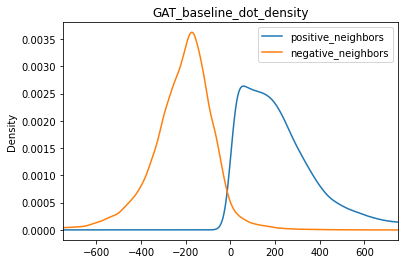

In [10]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [11]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
sp_score[model] = statistical_parity(edges, y)

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 323.21it/s]


((1346155, 2), 9.305690315709202e-06, 0.9919058765548299)

# GAT ( baseline + crosswalk)

In [12]:
model = "GAT_baseline_crosswalk"
emb = np.load(DATA_ROOT + 'pokec_crosswalk_gat_node2vec_embs.npy')
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269231/269231 [00:00<00:00, 380618.43it/s]


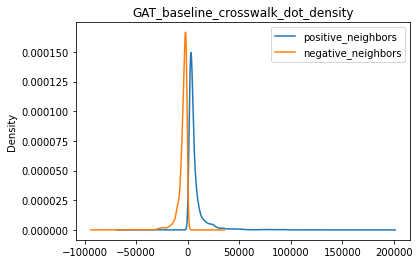

In [13]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [14]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
sp_score[model] = statistical_parity(edges, y)

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 318.00it/s]


((1346155, 2), 6.780123580324649e-06, 0.9995647335411509)

# GAT ( r2v)

In [15]:
model = "GAT_r2v"
emb = np.load(DATA_ROOT + 'pokec_gat_r2v_node2vec_embs.npy')
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269231/269231 [00:00<00:00, 327120.12it/s]


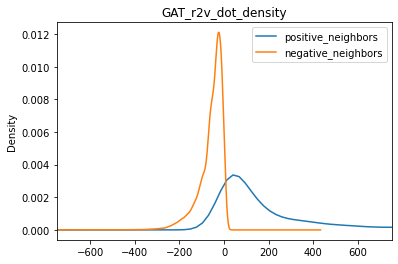

In [16]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [17]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
sp_score[model] = statistical_parity(edges, y)

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 327.44it/s]


((1346155, 2), 1.0932823801886484e-05, 0.9971550858687119)

# GAT ( r2v + crosswalk)

In [18]:
model = "GAT_r2v_crosswalk"
emb = np.load(DATA_ROOT + 'pokec_crosswalk_gat_r2v_node2vec_embs.npy')
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269231/269231 [00:00<00:00, 325823.65it/s]


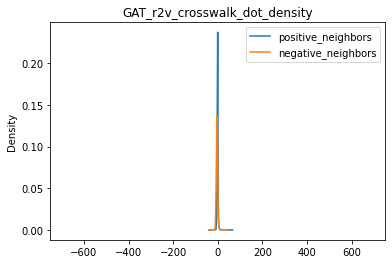

In [19]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [20]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
sp_score[model] = statistical_parity(edges, y)

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 295.72it/s]


((1346155, 2), 1.688383035618285e-05, 0.7713509572446086)

# plot statistical parity scores

GAT_baseline 9.305690315709202e-06
GAT_baseline_crosswalk 6.780123580324649e-06
GAT_r2v 1.0932823801886484e-05
GAT_r2v_crosswalk 1.688383035618285e-05


[Text(0, 0, 'GAT_baseline'),
 Text(1, 0, 'GAT_baseline_crosswalk'),
 Text(2, 0, 'GAT_r2v'),
 Text(3, 0, 'GAT_r2v_crosswalk')]

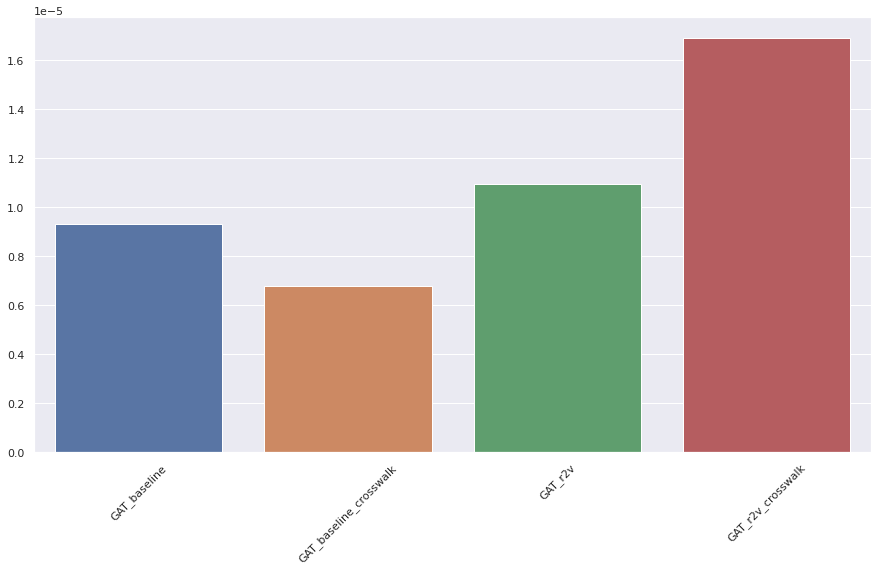

In [21]:
import seaborn as sns
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

GAT_baseline 0.9919058765548299
GAT_baseline_crosswalk 0.9995647335411509
GAT_r2v 0.9971550858687119
GAT_r2v_crosswalk 0.7713509572446086


[Text(0, 0, 'GAT_baseline'),
 Text(1, 0, 'GAT_baseline_crosswalk'),
 Text(2, 0, 'GAT_r2v'),
 Text(3, 0, 'GAT_r2v_crosswalk')]

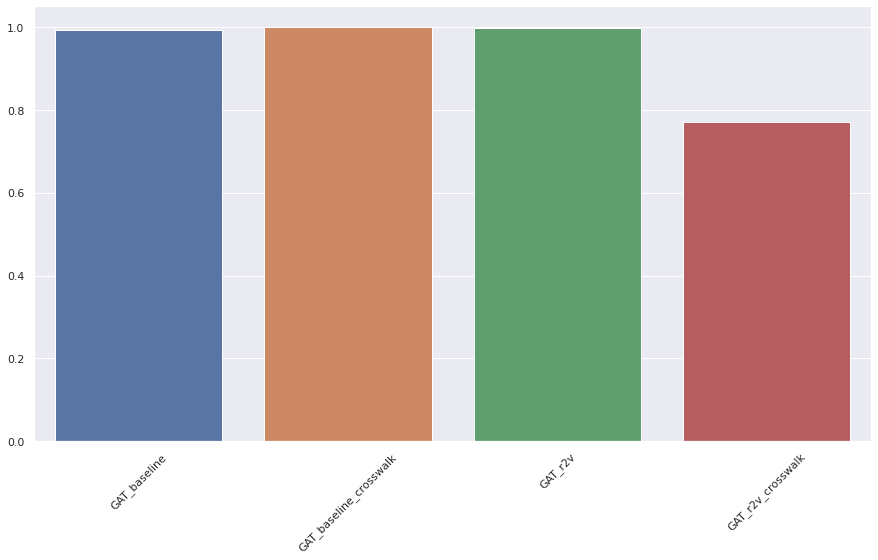

In [22]:
import seaborn as sns
for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)